# Import

In [122]:
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
# from pymoo.problems import get_problem
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
import statsmodels.api as sm

import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
import matplotlib.animation as animation
from matplotlib.widgets import Slider, Button

from scipy.interpolate import splev, splrep, LSQUnivariateSpline, PchipInterpolator
from scipy.interpolate import CubicSpline, Akima1DInterpolator, interp1d
from scipy.integrate import simps
from sklearn.linear_model import LinearRegression
from functools import partial
from random import shuffle
from sklearn import linear_model
from tqdm.notebook import trange, tqdm
from pynverse import inversefunc
import scipy as sp
from joblib import Parallel, delayed 
import pandas as pd
from routines_model import *
from routines_GA import *
from multiprocessing import Pool
import multiprocessing
import pickle
import emcee
import corner
import pygtc 
import os

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
from pymoo.termination import get_termination
from pymoo.optimize import minimize
from schwimmbad import JoblibPool

%load_ext line_profiler
%load_ext autoreload
%autoreload 2
# %reload_ext autoreload
# %matplotlib widget

rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 15

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

In [2]:
data_Fe = pd.read_excel("ODP1260/ODP 1260_Fe_80-135.5m.xlsx")
data_Fe = data_Fe.values

/obs/nhoanghoai/conda/myenv/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [177]:
depth = data_Fe[:,0]
depth_lims = depth[0], depth[-1]
depth_lims = 90, 125
ind = (depth>=depth_lims[0]) & (depth<=depth_lims[1])
y_data = data_Fe[ind,1]
depth = depth[ind]
# depth_original = depth 
lowess = sm.nonparametric.lowess(y_data, depth, frac=.3).T
# y = y_ori - lowess[1]
y = y_data-lowess[1]
# y = y_data - y_data.mean()
y = y/y.std()

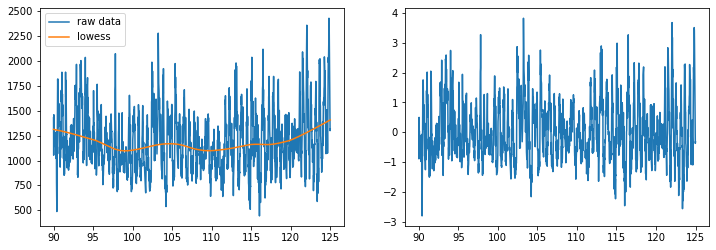

In [178]:
%matplotlib inline
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(depth, y_data, label="raw data")
plt.plot(depth, lowess[1], label="lowess")
plt.legend()
# plt.plot(depth, ydata_ma)
# plt.plot(depth, ydata-ydata_ma)
plt.subplot(1,2,2)
plt.plot(depth, y)


Age model by visual tuning

In [7]:
df_age_model = pd.read_csv("ODP1260/ggge20293-sup-0011-suppinfo06.txt", delimiter="\t")
depth_age_nominal = df_age_model[["Depth (rmcd)", "La2004 age (Ma)"]].to_numpy().T
depth_age_nominal = depth_age_nominal[:,:-1]
# depth_age_nominal[1] = depth_age_nominal[1]*1e3
df_age_model

,Depth (rmcd),La2004 age (Ma)
0,37.60,39.786
1,44.42,40.094
2,45.04,40.122
3,45.48,40.145
4,45.86,40.165
...,...,...
177,133.96,43.943
178,134.50,43.967
179,135.06,43.987
180,135.62,44.008


In [148]:
# ind = (depth_age_nominal[0]>=depth_lims[0]) & (depth_age_nominal[0]<=depth_lims[1])
# depth_age_nominal = depth_age_nominal[:, ind]
invSR_nominal = np.gradient(depth_age_nominal[1], depth_age_nominal[0])
func_invSR_nominal = interp1d(depth_age_nominal[0], invSR_nominal, kind="nearest" )
func_time_nominal = interp1d(depth_age_nominal[0], depth_age_nominal[1] )
# invSR_nominal = invSR_nominal[ind]
# SR_nominal = 1/invSR_nominal

Text(0.5, 0, 'm')

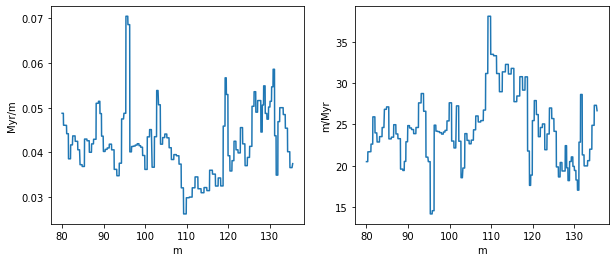

In [9]:
plt.figure(figsize=(10,4))
# plt.plot(*depth_age_nominal)
plt.subplot(1,2,1)
# plt.step(depth_age_nominal[0], invSR_nominal, where="mid")
plt.plot(depth, func_invSR_nominal(depth))
plt.ylabel("Myr/m")
plt.xlabel("m")
plt.subplot(1,2,2)
plt.plot(depth, 1/func_invSR_nominal(depth))
# plt.step(depth_age_nominal[0], SR_nominal)
plt.ylabel("m/Myr")
plt.xlabel("m")

# Model

In [180]:
coef_time = 1e6


b_k = np.array([0.018986, 0.016354, 0.013055, 0.008849, 0.004248])/0.022 #
muy_k = np.array([4.257564, 7.456665, 17.910194, 17.366595, 5.579378])
phi_k = np.array([30.739, -157.801, 140.577, -55.885, 77.107])
phi_k = phi_k/180/3600*np.pi
muy_k = muy_k/180/3600*np.pi*coef_time

p0 = 50.467718
# p0 = 40
p0 = p0/180/3600*np.pi*coef_time

# b_k

ordering = [4, 1, 3, 2, 0]
b_k = b_k[ordering]
muy_k = muy_k[ordering]
phi_k = phi_k[ordering]


fe_k = np.array([3.199279, 13.651920, 10.456224, 13.109803, 9.909679])
fe_k = fe_k/180/3600*np.pi*coef_time

fs = np.hstack([muy_k + p0, fe_k])
print(fs)
print(2*np.pi/fs)

[271.72398927 280.82533348 328.87002991 331.50547223 265.31565416
  15.51054229  66.18637589  50.69320448  63.55811851  48.04347955]
[0.02312341 0.022374   0.01910538 0.01895349 0.02368192 0.40509127
 0.0949317  0.12394532 0.09885732 0.13078123]


## Optimize

In [181]:
# N_population = 128 # number of individual in population 
# N_generations_max = 12
N_genes = 30 # number of intial gene in an individial of the population 
# depth_genes = np.linspace(0,1,N_genes)
depth_genes = np.linspace(depth_lims[0], depth_lims[1], N_genes)
# true_genes = func_inv_SR(depth_genes)
invSR_lims = [0.02, 0.1]
# fs = muy_k + p0
fs = np.hstack([muy_k + p0, fe_k])
# fs =  np.array([f1, f2])
# interpolator = interpolate_Akima
interpolator = interpolate_CubicSpline
invSR_to_predx =  partial(invSR_to_pred,  data=[depth, y], invSR_lims=invSR_lims, fs=fs, interpolator=interpolate_CubicSpline)

n_pieces = 2
metric_optimal = metric_piecewise([depth_genes, func_invSR_nominal(depth_genes)], [depth, y], fs, interpolator, n_pieces)
print(metric_optimal)
# invSR_all = np.zeros((N_generations_max, N_population, N_genes))
# invSR_ini = np.random.rand(N_population, N_genes)*invSR_lims[1]
# invSR_all[0] = invSR_ini
# metric_all = np.zeros((N_generations_max, N_population))
# metric_ini = np.array([metric([depth_genes, invSR_ini_i], [depth, y], fs, interpolator, metric_type="BIC") for invSR_ini_i in invSR_ini])
# metric_all[0] = metric_ini
interpolator = interpolate_CubicSpline
data = [depth, y]
problem = invSRinference(depth_genes, invSR_lims, interpolator, data, fs, n_pieces=n_pieces, metric=metric_piecewise)
out = {}
problem._evaluate(np.random.rand(len(depth_genes)), out)
out

[0.12720551 0.22286444]


{'F': array([-0.01679692, -0.04678263])}

## With nominal age model

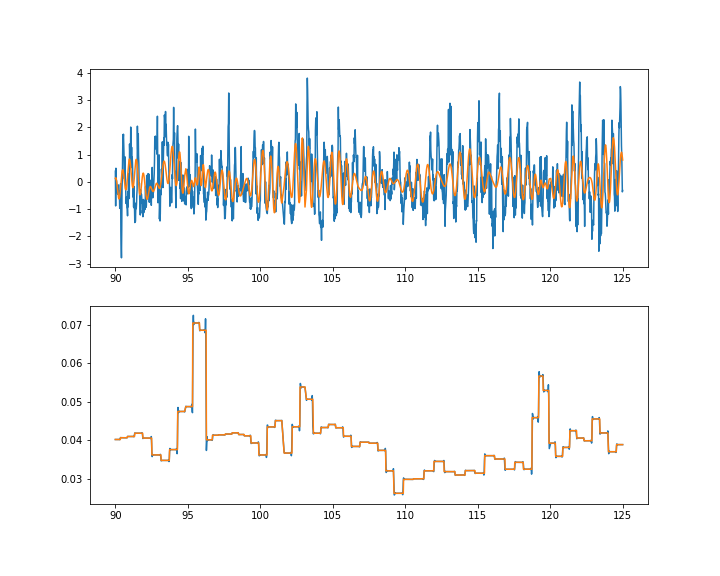

In [193]:
%matplotlib widget
depth_genes_test = np.linspace(depth_lims[0], depth_lims[1], 1000)

time, y_pred = invSR_to_predx([depth_genes_test, func_invSR_nominal(depth_genes_test)])
plt.figure(figsize=(10,8))
plt.subplot(2, 1,1)
plt.plot(depth, y)
plt.plot(depth, y_pred)
# plt.plot(func_time_nominal(depth)-func_time_nominal(depth[0]), y)
# plt.plot(time, y_pred)
plt.subplot(2,1,2)
# plt.plot(depth, y)
# plt.plot(depth, y_pred)
invSR_reconstruct = interpolator([depth_genes_test, func_invSR_nominal(depth_genes_test)], depth )
plt.plot(depth, invSR_reconstruct)
plt.plot(depth, func_invSR_nominal(depth))

# plt.plot(depth, time)

## GA

In [182]:
algorithm = NSGA2(
    pop_size=300,
    n_offsprings=100,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)

termination = get_termination("n_gen", 500)

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=True)

# X = res.X
# F = res.F

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |      300 |      7 |             - |             -
     2 |      400 |      8 |  0.0421075279 |             f
     3 |      500 |      9 |  0.1060429889 |         ideal
     4 |      600 |      4 |  0.0922098707 |         ideal
     5 |      700 |      2 |  0.4756747498 |         ideal
     6 |      800 |      4 |  0.2063843650 |         ideal
     7 |      900 |      5 |  0.0745900929 |         ideal
     8 |     1000 |      8 |  0.0365234321 |             f
     9 |     1100 |     10 |  0.0735434858 |         ideal
    10 |     1200 |      7 |  0.0320603350 |             f
    11 |     1300 |      7 |  0.1952956436 |         ideal
    12 |     1400 |      7 |  0.0089132671 |             f
    13 |     1500 |      9 |  0.1617155101 |         ideal
    14 |     1600 |     11 |  0.0167769983 |         ideal
    15 |     1700 |     14 |  0.0691054823 |         ideal
    16 |     1800 |     12 |  0.0173921203 |         ide

In [56]:
res = res_ensemble[-1]
depth_genes = depth_genes_ensemble[-1]

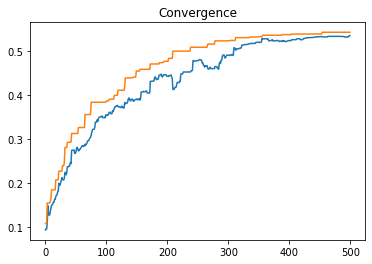

In [183]:
# opt = -np.array([e.opt[0].F for e in res.history])
opt_mean = np.array([ np.mean([-eiopt.F for eiopt in e.opt]) for e in res.history])
opt_max = np.array([ np.max(np.mean(np.array([-eiopt.F for eiopt in e.opt]), axis=1)) for e in res.history])

plt.figure()
plt.title("Convergence")
# plt.plot(opt.mean(axis=1), "--")
plt.plot(opt_mean)
plt.plot(opt_max)

# plt.yscale("log")
plt.show()


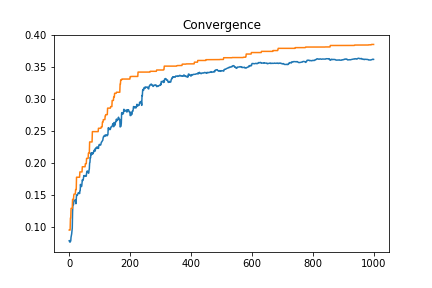

In [62]:
# opt = -np.array([e.opt[0].F for e in res.history])
opt_mean = np.array([ np.mean([-eiopt.F for eiopt in e.opt]) for e in res.history])
opt_max = np.array([ np.max(np.mean(np.array([-eiopt.F for eiopt in e.opt]), axis=1)) for e in res.history])

plt.figure()
plt.title("Convergence")
# plt.plot(opt.mean(axis=1), "--")
plt.plot(opt_mean)
plt.plot(opt_max)

# plt.yscale("log")
plt.show()


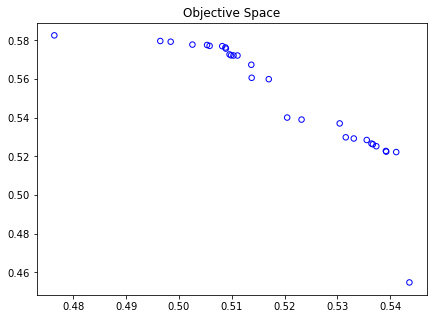

In [184]:
%matplotlib inline
plt.figure(figsize=(7, 5))
plt.scatter(-res.F[:, 0], -res.F[:, 1], s=30, facecolors='none', edgecolors='blue')
f1min, f1max = -res.F[:,0].min(), -res.F[:,0].max()
f1grid = np.linspace(0, 1, 100)

# for i in range(res.F.shape[0]):
#     plt.plot(f1grid, -res.F[i,0] + -res.F[i,1] - f1grid, color="black",alpha=0.5)
plt.title("Objective Space")
# plt.xlim([0,1])
# plt.ylim([0,1])
# plt.plot(metric_optimal[0],metric_optimal[1], "d", color="black")
plt.show()


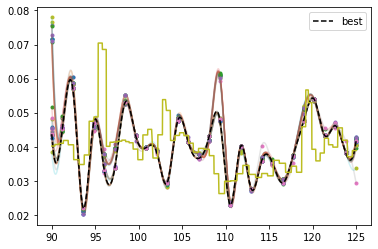

In [185]:
%matplotlib inline
# invSR_interpolate = interpolator([depth_genes, invSR_best], depth)
res.F.shape, res.X.shape
arg_best = np.argmin(res.F.sum(axis=1)/2)
invSR_best = res.X[arg_best]
fig = plt.figure()
for i in range(res.F.shape[0]):
    plt.plot(depth_genes, res.X[i], '.')
    invSR_interpolate = interpolator([depth_genes, res.X[i]], depth)
    invSR_interpolate[invSR_interpolate<invSR_lims[0]] = invSR_lims[0]
    invSR_interpolate[invSR_interpolate>invSR_lims[1]] = invSR_lims[1]
    plt.plot(depth, invSR_interpolate, alpha=0.2)
# plt.plot(depth, invSR, color="red")
plt.plot(depth, interpolator([depth_genes, invSR_best], depth), "--", color="black", label="best")
# plt.plot(depth, interpolator([depth_genes, func_invSR_nominal(depth_genes)], depth), color="red", label="nominal")
plt.plot(depth, func_invSR_nominal(depth))
# invSR_interpolate[invSR_interpolate<0] = 0
plt.legend()
# time = sp.integrate.cumulative_trapezoid(invSR_interpolate, depth, initial=0)
# X = generate_X_linReg(np.ones_like(fs), fs, time)

# reg_model = LinearRegression().fit(X, y_data)
# y_pred = reg_model.predict(X)

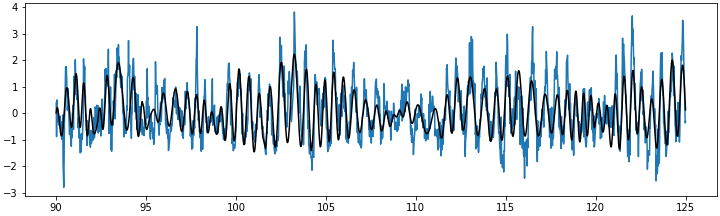

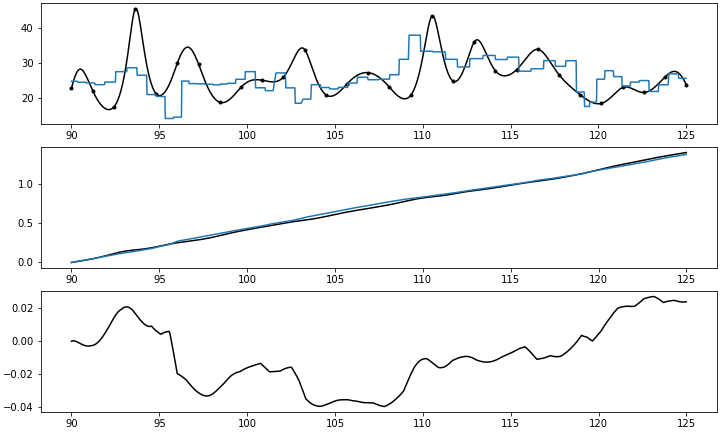

In [214]:
%matplotlib widget
fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(10,3))
ax.plot(depth, y)
# axs[0].plot(depth_age[0], (depth_age[1]-depth_age[1,0] ))
# for i in range(res.F.shape[0]):

#     # invSR_interpolate = interpolator([depth_genes, res.X[i]], depth)
#     time, y_pred = invSR_to_predx([depth_genes, res.X[i]])
    
#     axs[1].plot(depth, y_pred, alpha=0.1, color="black")
#     axs[0].plot(depth, time, alpha=0.3, color="black")
    
time_best, y_pred = invSR_to_predx([depth_genes, invSR_best])

# axs[0].plot(depth, time, color="black")
# 
ax.plot(depth, y_pred, color="black")

time_nominal, y_pred = invSR_to_predx([depth_genes, func_invSR_nominal(depth_genes)])
# axs[1].plot(depth, y_pred,  color="red")
# axs[0].plot(depth, time, color="red")


# axs[1].plot(depth, interpolator([depth_genes, res.X[arg_best]], depth), color="black")
# axs[1].plot(depth_genes, res.X[arg_best], '.', color="black")
# axs[1].plot(depth, func_invSR_nominal(depth))
fig, axs = plt.subplots(3, 1, constrained_layout=True, figsize=(10,6))

axs[0].plot(depth, 1/interpolator([depth_genes, res.X[arg_best]], depth), color="black")
axs[0].plot(depth_genes, 1/res.X[arg_best], '.', color="black")
axs[0].plot(depth, 1/func_invSR_nominal(depth))

axs[1].plot(depth, time_best, color="black")
# axs[1].plot(depth, time_nominal)
axs[1].plot(depth, func_time_nominal(depth)-func_time_nominal(depth[0]))
# axs[1].plot(depth, time_best-time_nominal, color="black")
axs[2].plot(depth, time_best-func_time_nominal(depth)+func_time_nominal(depth[0]), color="black")


# axs[0].plot(depth, interpolator([depth_genes, res.X[i]], depth))

# for i in range(2):
#     axs[i].set_xlim([90, 100])

### In search for optimial number of genes

In [49]:
algorithm = NSGA2(
    pop_size=200,
    n_offsprings=100,
    sampling=FloatRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(eta=20),
    eliminate_duplicates=True
)
N_generations = 500
termination = get_termination("n_gen", N_generations)
N_genes_enemble = np.arange(10, 30, 2)
depth_genes_ensemble = [np.linspace(depth_lims[0], depth_lims[1], N_genes) for N_genes in N_genes_enemble] 
N_ensemble = len(depth_genes_ensemble)

problems = [invSRinference(depth_genes, invSR_lims, interpolator, data, fs, n_pieces=2, metric=metric_piecewise) for depth_genes in depth_genes_ensemble  ] 


res_ensemble = Parallel(n_jobs=N_ensemble, verbose=100)(delayed(minimize)(problem, algorithm, termination, save_history=True) for problem in problems)


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   1 tasks      | elapsed:  5.6min
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:  7.7min remaining: 30.7min
[Parallel(n_jobs=10)]: Done   3 out of  10 | elapsed:  8.2min remaining: 19.2min
[Parallel(n_jobs=10)]: Done   4 out of  10 | elapsed:  8.3min remaining: 12.4min
[Parallel(n_jobs=10)]: Done   5 out of  10 | elapsed:  8.5min remaining:  8.5min
[Parallel(n_jobs=10)]: Done   6 out of  10 | elapsed:  8.6min remaining:  5.7min
[Parallel(n_jobs=10)]: Done   7 out of  10 | elapsed:  8.7min remaining:  3.7min
[Parallel(n_jobs=10)]: Done   8 out of  10 | elapsed:  8.9min remaining:  2.2min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:  9.1min remaining:    0.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:  9.1min finished


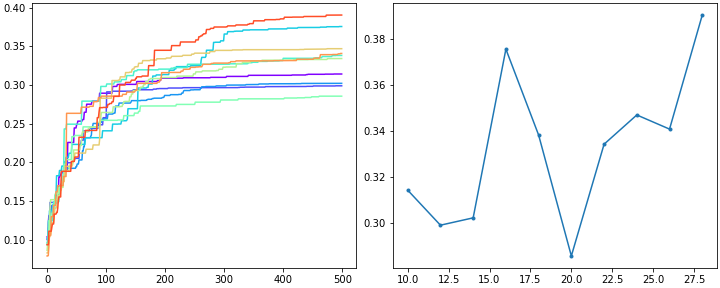

In [50]:
# opt = -np.array([e.opt[0].F for e in res.history])
# opt_mean = np.array([ np.mean([-eiopt.F for eiopt in e.opt]) for e in res.history])

plt.figure(figsize=(10, 4), constrained_layout=True)
plt.title("Convergence")
plt.subplot(1,2,1)

cmap = plt.get_cmap("rainbow")

opt_max_ensemble = np.zeros([N_ensemble,N_generations])
for i in range(N_ensemble):
    res = res_ensemble[i]
    opt_max_ensemble[i] = np.array([ np.max(np.mean(np.array([-eiopt.F for eiopt in e.opt]), axis=1)) for e in res.history])

    # plt.plot(opt_max_ensemble[i], color=cmap(i/N_ensemble))
    plt.plot(opt_max_ensemble[i], color=cmap(i/N_ensemble))

# plt.yscale("log")
plt.subplot(1,2,2)
plt.plot(N_genes_enemble, opt_max_ensemble[:,-1], '.-')

# MCMC

In [78]:
# log_probability_testcase()

In [117]:
def log_likelihood_whitenoise(invSR, fs, sigma, interpolator=interpolate_CubicSpline, *args, **kwargs):
    """_summary_: 
    
        loglikelihood for the linear model with predictors variable are fourier harmonics of frequencies fs
        of fitting the data, when used the age model derived from the invSR.
        age model: given points of inverse SR, interpolate with an interpolator and integrate along depth
        to obtain time.
    Args:
        invSR (array[2,n]): inverse of sedimetation rates and their corresponding depth 
        interpolator: interpolator
        data (array[2,m]): the data and corresponding depth
        fs (_type_): list of frequencies of the model
        sigma2: variance of the residual misfit 
           
    """

    depth, y_data = data

    invSR_interpolate = interpolator(invSR, depth)
    # invSR_interpolate[invSR_interpolate<0] = 0
    
    time = sp.integrate.cumulative_trapezoid(invSR_interpolate, depth, initial=0)
    X = generate_X_linReg(np.ones_like(fs), fs, time)

    reg_model = LinearRegression().fit(X, y_data)
    y_pred = reg_model.predict(X)
    # Residual Sum Square
    RSS = np.sum((y_data - y_pred)**2)
    N = len(y_data)

    return -0.5 * RSS / sigma**2 - N*np.log(sigma)

def log_posterior_whitenoise_v1(params, depth_invSR, fs, interpolator=interpolate_CubicSpline, invSR_lims=[0,2], sigma_lims=[1e-4, 2]):
    """log of posterior for the
        linear model with predictors variable are fourier harmonics of constant frequencies fs
        with the age model derived from the invSR.
        age model: given points of inverse SR, interpolate with an interpolator and integrate along depth to obtain time.
        with white noise
        log posterior = log likelihood + log prior
        prior for invSR is uniform, sigma is loguniform
    Args:
        params: array[1 + N_genes] = [sigma (whitenoise), array of invSR]
        depth_invSR (_type_): depth of invSR
        data (array[2,m]):  depth and corresponding data
        fs (array): frequencies 
        interpolator (_type_, optional). Defaults to interpolate_CubicSpline.
        invSR_lims (list, optional): limit of inSR. Defaults to [0,2].
        invSR_lims (list, optional): limit of inSR. Defaults to [0,2].
    Returns:
        log posterior = log likelihood + log prior
    """
    sigma =  params[0]
    invSR = params[1:]
    lp_invSR = log_uniform(invSR, invSR_lims)
    lp_sigma = log_loguniform(sigma, sigma_lims)    
    lp = lp_invSR + lp_sigma
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_whitenoise([depth_invSR, invSR], fs, sigma, interpolator=interpolator)

In [ ]:
prior_params_freq = np.array([[50.5, 10], [5.525, 0.125], [7.455, 0.015], [17.3, 0.15], [17.85, 0.15], [4.257564, 0.00002]])
prior_params_freq = prior_params_freq/180/3600*np.pi*1e6

In [125]:
arg_best = np.argmin(res.F.sum(axis=1))
invSR_best = res.X[arg_best]
invSR_random = np.random.randn(N_genes)*(invSR_lims[1]-invSR_lims[0]) + invSR_lims[0]

nwalkers = 64
params_noise_ini = [0.8]
params_ini = np.hstack([params_noise_ini, invSR_best])
pos = params_ini + 1e-4 * np.random.randn(nwalkers, N_genes+len(params_noise_ini))
# pos = invSR_random + 1e-4 * np.random.randn(nwalkers, N_genes)

nwalkers, ndim = pos.shape
# log_posterior = log_posterior_whitenoise_v1
# log_probability_testcase = partial(log_posterior, depth_invSR=depth_genes, data=[depth, y], fs=fs, interpolator=interpolate_CubicSpline, invSR_lims=invSR_lims) 

log_posterior = log_posterior_whitenoise
log_probability_testcase = partial(log_posterior, depth_invSR=depth_genes, data=[depth, y],interpolator=interpolate_CubicSpline,
                                   invSR_lims=invSR_lims, sigma_lims=[1e-4, 2], prior_freq=prior_params_freq) 

# with Pool(processes=1) as pool:

with JoblibPool(32) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_testcase, pool=pool)
    sampler.run_mcmc(pos, 5000, progress=True)
    # print("Multiprocessing took {0:.1f} seconds".format(multi_time))

100%|██████████| 5000/5000 [13:44<00:00,  6.07it/s]


In [92]:
# %lprun -f log_posterior_whitenoise_v1  log_posterior_whitenoise_v1(params_ini, depth_invSR=depth_genes, data=[depth, y],interpolator=interpolate_CubicSpline, invSR_lims=invSR_lims,  fs=fs)         
%lprun -f log_likelihood_whitenoise  log_likelihood_whitenoise([depth_genes, invSR_best], data=[depth, y],interpolator=interpolate_CubicSpline, invSR_lims=invSR_lims,  fs=fs, sigma=0.8)         
    

Timer unit: 1e-09 s

Total time: 0.0555837 s
File: /users/nhoanghoai/AstroGeo/routines_model.py
Function: log_likelihood_whitenoise at line 244

Line #      Hits         Time  Per Hit   % Time  Line Contents
   244                                           def log_likelihood_whitenoise(invSR, data, fs, sigma, interpolator=interpolate_CubicSpline, *args, **kwargs):
   245                                               """_summary_: 
   246                                               
   247                                                   loglikelihood for the linear model with predictors variable are fourier harmonics of frequencies fs
   248                                                   of fitting the data, when used the age model derived from the invSR.
   249                                                   age model: given points of inverse SR, interpolate with an interpolator and integrate along depth
   250                                                   to obtain time.


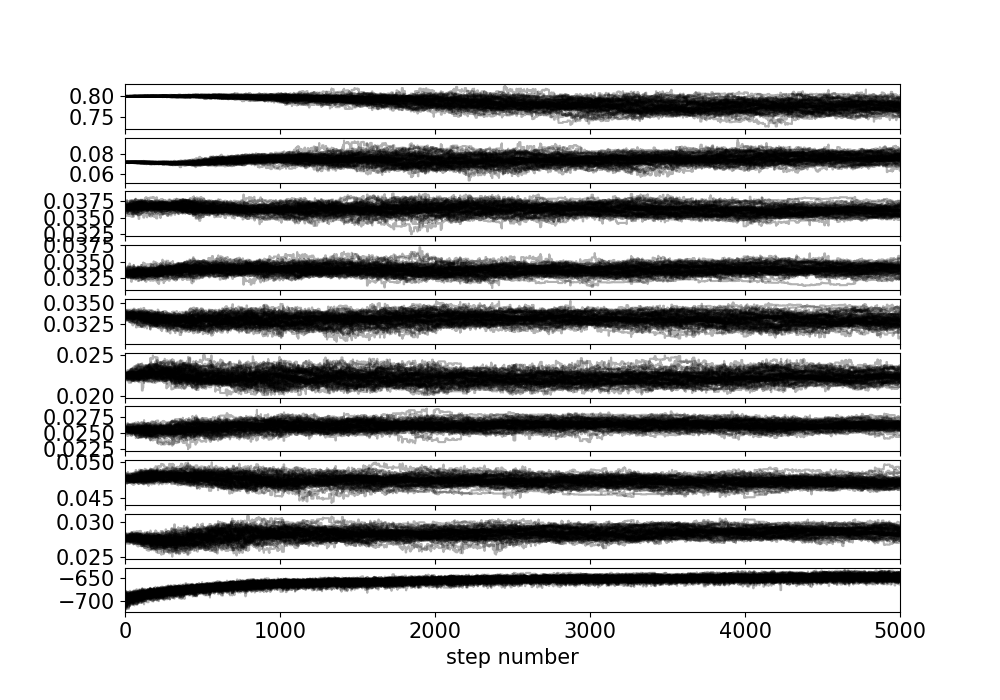

In [126]:
ndim = 10
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
logprob_sample = sampler.get_log_prob()

# labels = ["m", "b", "log(f)"]
for i in range(ndim-1):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    # ax.set_ylabel(labels[i])
    # ax.yaxis.set_label_coords(-0.1, 0.5)


axes[-1].plot(logprob_sample, "k", alpha=0.3)
axes[-1].set_xlabel("step number");     

In [131]:
flat_samples = sampler.get_chain(discard=1000, thin=50, flat=True)
print(flat_samples.shape)

(5120, 31)


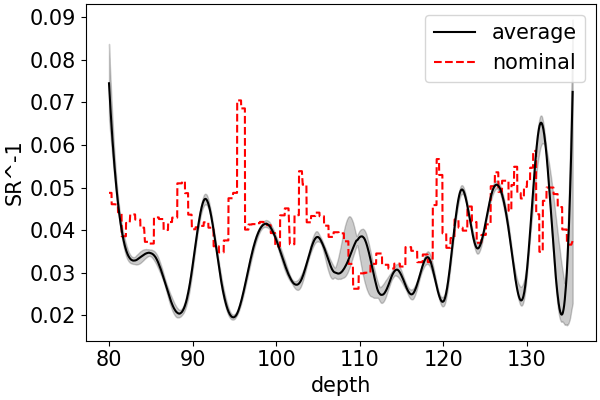

In [132]:
inds = np.random.randint(len(flat_samples), size=1000)
# genes_value = flat_samples[:,1+len(freqs_true)+i]
invSR_interpolate_par = np.array([interpolator([depth_genes, flat_samples[i,1:]], depth) for i in inds])
# invSR_interpolate_par = invSR_interpolate_par[metric_best<500]

# invSR_par = [invSR_all[-1][0] for invSR_all in invSR_all_para]
mean_invSR = np.median(invSR_interpolate_par,axis=0)
invSR_lo, invSR_up = np.quantile(invSR_interpolate_par, [0.025, 0.975],axis=0)

fig1 = plt.figure(constrained_layout=True)
# plt.title(f"estimation from {n_para} populations")
plt.plot(depth, mean_invSR, zorder=10,color="black", label="average")
# plt.plot(depth, best_invSR, "--",color="black", label="best", zorder=10)

plt.fill_between(depth, invSR_lo, invSR_up, alpha=0.2, color="black")
plt.plot(depth, func_invSR_nominal(depth), "--", color="red", label="nominal")
plt.xlabel("depth")
plt.ylabel("SR^-1")
plt.legend()